<a href="https://colab.research.google.com/github/cacaprog/cemel-analysis/blob/main/cemel_pesquisa_pais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['axes.unicode_minus'] = False

print("=== ANÁLISE EXPLORATÓRIA CEMEL 2025 ===")

=== ANÁLISE EXPLORATÓRIA CEMEL 2025 ===


In [24]:
# CARREGAR DADOS
df = pd.read_csv('/content/cemel_pesquisa_pais.csv')

print(f"Total de respostas: {len(df)}")
print(f"Total de colunas: {len(df.columns)}")

# Definir colunas principais
nps_column = "Em uma escala de 0 a 10, qual a probabilidade de você recomendar o CEMEL para outras famílias?"
intencao_column = "Qual sua intenção para a rematrícula de 2026?"
tempo_column = "Há quanto tempo seu(s) filho(s) estuda(m) no CEMEL?"
fatores_column = "Quais fatores estão influenciando sua dúvida ou decisão de não renovar?"

# Dimensões para análise
dimensoes = {
    "Como você avalia a qualidade do ensino oferecido pelo CEMEL?": "Qualidade do Ensino",
    "Como você avalia a comunicação da escola com as famílias?": "Comunicação",
    "Como você avalia o custo-benefício do CEMEL?": "Custo-Benefício",
    "Como você avalia o atendimento da secretaria/administrativo?": "Atendimento Secretaria",
    "Como você avalia o relacionamento e competência dos professores e coordenação?": "Professores e Coordenação"
}

Total de respostas: 127
Total de colunas: 29


In [25]:
df.head()

,Carimbo de data/hora,Nome,E-mail para contato,WhatsApp para contato,Em que ano(s) seu(s) filho(s) está(ão) matriculado(s) no CEMEL?,Há quanto tempo seu(s) filho(s) estuda(m) no CEMEL?,Como você avalia a qualidade do ensino oferecido pelo CEMEL?,Em que grau você percebe o desenvolvimento acadêmico e pessoal do seu filho no CEMEL?,A metodologia pedagógica da escola atende às necessidades do seu filho?,Como você avalia o relacionamento e competência dos professores e coordenação?,...,A direção da escola está disponível quando necessário?,Como você avalia o custo-benefício do CEMEL?,Quais são os principais diferenciais que você enxerga no CEMEL?,"Em uma escala de 0 a 10, qual a probabilidade de você recomendar o CEMEL para outras famílias?",Qual sua intenção para a rematrícula de 2026?,Quais fatores estão influenciando sua dúvida ou decisão de não renovar?,O que o CEMEL faz de MELHOR na sua opinião?,O que o CEMEL poderia MELHORAR?,Você tem alguma sugestão específica para a escola?,Gostaria de compartilhar mais alguma coisa conosco?
0,20/08/2025 14:38:13,Rafaela Silva,Rafaela_marina@hotmail.com,11988316815,Educação Infantil - Pré II,Entre 2 a 4 anos,Excelente,Muito acima das expectativas,Atende completamente,Excelente,...,Sempre,Excelente,"Qualidade do ensino, Atenção individualizada, ...",10,Já decidi renovar a matrícula,NaN,O Ensino e a metodologia.,Não há.,não,NaN
1,20/08/2025 14:39:56,Lais Martins,mendes.laiis95@gmail.com,11954965015,Ensino Fundamental - 4º ano,5 anos ou mais,Muito bom,Acima das expectativas,Atende completamente,Muito bom,...,Sempre,Excelente,"Qualidade do ensino, Atenção individualizada, ...",10,Já decidi renovar a matrícula,NaN,Conciliar educação infantil com princípios,"As aulas de informática, poderiam ter mais con...",Aprimorar o ensino de informática,NaN
2,20/08/2025 14:40:04,Jonathan da Cruz Santos,jonathan10web@gmail.com,11986885274,Ensino Fundamental - 1º ano,Entre 2 a 4 anos,Bom,Dentro das expectativas,É adequada,Bom,...,Sempre,Excelente,"Valores e princípios, Relacionamento família-e...",10,Provavelmente vou renovar,NaN,Eventos aos alunos,Sistema de avaliação,NaN,NaN
3,20/08/2025 14:42:29,Haira Fernandes,hairabritofernandes@gmail.com,1199007-2517,Educação Infantil - Pré I,Entre 2 a 4 anos,Bom,Dentro das expectativas,Precisa de ajustes,Regular,...,Na maioria das vezes,Muito bom,"Valores e princípios, Tradição e credibilidade...",8,Já decidi renovar a matrícula,NaN,O ponto mais forte do CEMEL é o ambiente acolh...,Acredito que o CEMEL poderia melhorar no senti...,NaN,NaN
4,20/08/2025 14:42:47,Alexandre Silva Ribeiro,aalexandresr@uol.com.br,11 998165225,Ensino Fundamental - 3º ano,Entre 2 a 4 anos,Excelente,Acima das expectativas,Atende completamente,Excelente,...,Sempre,Excelente,"Qualidade do ensino, Valores e princípios, Rel...",10,Já decidi renovar a matrícula,NaN,Ensino,Não tenho nada em mente,NaN,NaN


In [26]:
df['Há quanto tempo seu(s) filho(s) estuda(m) no CEMEL?'].value_counts()

,count
Há quanto tempo seu(s) filho(s) estuda(m) no CEMEL?,
Entre 2 a 4 anos,69
5 anos ou mais,47
Este é o primeiro ano (2025),10
Meu filho está no último ano antes da formatura,1



# ======================================
# FUNÇÕES AUXILIARES
# ======================================

In [31]:
def categorizar_tempo(tempo_str):
    """Categoriza o tempo de permanência em 3 grupos específicos"""
    if pd.isna(tempo_str):
        return "Não informado"

    tempo_lower = str(tempo_str).lower()

    # Novatos: matricularam em 2025
    if 'este é o primeiro ano (2025)' in tempo_lower or 'meses' in tempo_lower:
        return "Novatos (2025)"
    # Intermediários: 2 a 4 anos
    elif any(periodo in tempo_lower for periodo in ['1 ano', '2 anos', '3 anos', '4 anos']):
        return "Intermediários (2-4 anos)"
    # Veteranos: 5 anos ou mais
    elif '5 anos' in tempo_lower or 'mais de 5' in tempo_lower or any(periodo in tempo_lower for periodo in ['6 anos', '7 anos', '8 anos', '9 anos', '10 anos']):
        return "Veteranos (5+ anos)"
    else:
        return "Outros"

def converter_resposta_para_score(resposta):
    """Converte respostas qualitativas em scores de 1-5"""
    if pd.isna(resposta):
        return np.nan

    resposta_lower = str(resposta).lower()

    if 'excelente' in resposta_lower:
        return 5
    elif 'muito bom' in resposta_lower or 'muito boa' in resposta_lower:
        return 4
    elif 'bom' in resposta_lower or 'boa' in resposta_lower:
        return 3
    elif 'regular' in resposta_lower or 'adequado' in resposta_lower:
        return 2
    elif 'ruim' in resposta_lower or 'inadequado' in resposta_lower:
        return 1
    else:
        return np.nan

# Preparar DataFrame para análise
df_analise = df.copy()
df_analise['grupo_tempo'] = df_analise[tempo_column].apply(categorizar_tempo)

# Converter dimensões para scores numéricos
for pergunta, label in dimensoes.items():
    if pergunta in df.columns:
        df_analise[f'score_{label}'] = df_analise[pergunta].apply(converter_resposta_para_score)

# Definir grupos principais e cores
grupos_principais = ['Novatos (2025)', 'Intermediários (2-4 anos)', 'Veteranos (5+ anos)']
cores_grupos = {
    'Novatos (2025)': '#ff6b6b',
    'Intermediários (2-4 anos)': '#4ecdc4',
    'Veteranos (5+ anos)': '#45b7d1'
}

In [32]:
df_analise['grupo_tempo'].value_counts()

,count
grupo_tempo,
Intermediários (2-4 anos),69
Veteranos (5+ anos),47
Novatos (2025),10
Outros,1


# ======================================
# 1. ANÁLISE NPS GERAL
# ======================================

In [33]:
print("\n" + "="*50)
print("1. 📊 ANÁLISE NPS (Net Promoter Score)")
print("="*50)

nps_scores = df[nps_column].dropna()

# Classificação NPS
promotores = len(nps_scores[nps_scores >= 9])
neutros = len(nps_scores[(nps_scores >= 7) & (nps_scores <= 8)])
detratores = len(nps_scores[nps_scores <= 6])

nps_final = round(((promotores - detratores) / len(nps_scores)) * 100)
nps_medio = nps_scores.mean()

print(f"NPS Final: {nps_final} (Classificação: {'Excelente' if nps_final >= 75 else 'Muito Bom' if nps_final >= 50 else 'Bom' if nps_final >= 0 else 'Crítico'})")
print(f"Média das notas: {nps_medio:.2f}/10")
print(f"Promotores (9-10): {promotores} ({promotores/len(nps_scores)*100:.1f}%)")
print(f"Neutros (7-8): {neutros} ({neutros/len(nps_scores)*100:.1f}%)")
print(f"Detratores (0-6): {detratores} ({detratores/len(nps_scores)*100:.1f}%)")



1. 📊 ANÁLISE NPS (Net Promoter Score)
NPS Final: 82 (Classificação: Excelente)
Média das notas: 9.43/10
Promotores (9-10): 106 (83.5%)
Neutros (7-8): 19 (15.0%)
Detratores (0-6): 2 (1.6%)


# ======================================
# 2. ANÁLISE INTENÇÃO DE REMATRÍCULA
# ======================================

In [34]:
print("\n" + "="*50)
print("2. 🎯 ANÁLISE DE INTENÇÃO DE REMATRÍCULA")
print("="*50)

intencoes = df[intencao_column].value_counts()
total_intencoes = intencoes.sum()

for intent, count in intencoes.items():
    percentage = count/total_intencoes*100
    stars = '█' * int(percentage/5)
    print(f"{intent}: {count} ({percentage:.1f}%) {stars}")

# Resumo por categorias
renovacao_certa = intencoes.get("Já decidi renovar a matrícula", 0) + intencoes.get("Provavelmente vou renovar", 0)
indecisos = intencoes.get("Ainda estou avaliando", 0)
em_risco = intencoes.get("Já decidi não renovar", 0) + intencoes.get("Provavelmente não vou renovar", 0)

print(f"\n📊 RESUMO:")
print(f"✅ Renovação provável/certa: {renovacao_certa} ({renovacao_certa/total_intencoes*100:.1f}%)")
print(f"⚠️ Indecisos: {indecisos} ({indecisos/total_intencoes*100:.1f}%)")
print(f"❌ Em risco de evasão: {em_risco} ({em_risco/total_intencoes*100:.1f}%)")



2. 🎯 ANÁLISE DE INTENÇÃO DE REMATRÍCULA
Já decidi renovar a matrícula: 65 (51.2%) ██████████
Provavelmente vou renovar: 37 (29.1%) █████
Ainda estou avaliando: 19 (15.0%) ██
Já decidi não renovar: 3 (2.4%) 
Provavelmente não vou renovar: 3 (2.4%) 

📊 RESUMO:
✅ Renovação provável/certa: 102 (80.3%)
⚠️ Indecisos: 19 (15.0%)
❌ Em risco de evasão: 6 (4.7%)


# ======================================
# 3. ANÁLISE POR GRUPOS DE TEMPO
# ======================================

In [35]:
print("\n" + "="*50)
print("3. ⏰ ANÁLISE POR GRUPOS DE TEMPO")
print("="*50)

grupos_tempo = df_analise['grupo_tempo'].value_counts()

print("📊 DISTRIBUIÇÃO POR GRUPOS:")
for grupo, count in grupos_tempo.items():
    percentage = count/len(df_analise)*100
    print(f"• {grupo}: {count} famílias ({percentage:.1f}%)")

# NPS por grupo de tempo
print(f"\n📈 NPS MÉDIO POR GRUPO:")
nps_por_tempo = df_analise.groupby('grupo_tempo')[nps_column].agg(['mean', 'count']).round(2)
nps_por_tempo = nps_por_tempo.sort_values('mean', ascending=False)

for grupo in nps_por_tempo.index:
    media = nps_por_tempo.loc[grupo, 'mean']
    count = nps_por_tempo.loc[grupo, 'count']

    # Status baseado no NPS
    if media >= 8.5:
        status = "🟢 EXCELENTE"
    elif media >= 7.5:
        status = "🟡 BOM"
    else:
        status = "🔴 CRÍTICO"

    print(f"• {grupo}: {media:.2f} (n={count}) {status}")


3. ⏰ ANÁLISE POR GRUPOS DE TEMPO
📊 DISTRIBUIÇÃO POR GRUPOS:
• Intermediários (2-4 anos): 69 famílias (54.3%)
• Veteranos (5+ anos): 47 famílias (37.0%)
• Novatos (2025): 10 famílias (7.9%)
• Outros: 1 famílias (0.8%)

📈 NPS MÉDIO POR GRUPO:
• Veteranos (5+ anos): 9.51 (n=47) 🟢 EXCELENTE
• Intermediários (2-4 anos): 9.45 (n=69) 🟢 EXCELENTE
• Novatos (2025): 9.00 (n=10) 🟢 EXCELENTE
• Outros: 9.00 (n=1) 🟢 EXCELENTE


# ======================================
# 4. ANÁLISE CRUZADA: NPS x DIMENSÕES x TEMPO
# ======================================

In [36]:
print("\n" + "="*50)
print("4. 🔍 ANÁLISE CRUZADA: NPS x DIMENSÕES x TEMPO")
print("="*50)

# Criar matriz de análise cruzada
matriz_analise = {}
for pergunta, label in dimensoes.items():
    if pergunta in df.columns:
        matriz_analise[label] = {}

        for grupo in grupos_principais:
            if grupo in grupos_tempo.index:
                mask = df_analise['grupo_tempo'] == grupo
                scores = df_analise.loc[mask, f'score_{label}'].dropna()
                nps_grupo = df_analise.loc[mask, nps_column].dropna()

                if len(scores) > 0 and len(nps_grupo) > 0:
                    matriz_analise[label][grupo] = {
                        'score_dimensao': scores.mean(),
                        'nps_medio': nps_grupo.mean(),
                        'count': len(scores)
                    }

# Apresentar análise cruzada detalhada
print("🎯 PERFORMANCE POR GRUPO E DIMENSÃO:")
print("   " + "-" * 70)
print("   Grupo → Score Dimensão | NPS Médio | N° Respostas | Status")
print("   " + "-" * 70)

for dimensao, dados_grupos in matriz_analise.items():
    print(f"\n📋 {dimensao.upper()}:")

    # Ordenar grupos por NPS médio
    grupos_ordenados = sorted(dados_grupos.items(),
                             key=lambda x: x[1]['nps_medio'],
                             reverse=True)

    for grupo, dados in grupos_ordenados:
        score_dim = dados['score_dimensao']
        nps_med = dados['nps_medio']
        count = dados['count']

        # Status baseado no score da dimensão
        if score_dim >= 4.0:
            status_dim = "🟢"
        elif score_dim >= 3.0:
            status_dim = "🟡"
        else:
            status_dim = "🔴"

        print(f"   {status_dim} {grupo:<22} → {score_dim:.2f}/5.0 | {nps_med:5.2f} | {count:3d}")



4. 🔍 ANÁLISE CRUZADA: NPS x DIMENSÕES x TEMPO
🎯 PERFORMANCE POR GRUPO E DIMENSÃO:
   ----------------------------------------------------------------------
   Grupo → Score Dimensão | NPS Médio | N° Respostas | Status
   ----------------------------------------------------------------------

📋 QUALIDADE DO ENSINO:
   🟢 Veteranos (5+ anos)    → 4.39/5.0 |  9.51 |  46
   🟢 Intermediários (2-4 anos) → 4.32/5.0 |  9.45 |  69
   🟢 Novatos (2025)         → 4.33/5.0 |  9.00 |   9

📋 COMUNICAÇÃO:
   🟢 Veteranos (5+ anos)    → 4.29/5.0 |  9.51 |  45
   🟢 Intermediários (2-4 anos) → 4.36/5.0 |  9.45 |  64
   🟢 Novatos (2025)         → 4.56/5.0 |  9.00 |   9

📋 CUSTO-BENEFÍCIO:
   🟡 Veteranos (5+ anos)    → 3.93/5.0 |  9.51 |  46
   🟡 Intermediários (2-4 anos) → 3.91/5.0 |  9.45 |  69
   🟢 Novatos (2025)         → 4.00/5.0 |  9.00 |  10

📋 ATENDIMENTO SECRETARIA:
   🟢 Veteranos (5+ anos)    → 4.36/5.0 |  9.51 |  47
   🟢 Intermediários (2-4 anos) → 4.33/5.0 |  9.45 |  67
   🟢 Novatos (2025)      

# ======================================
# 5. ANÁLISE DE RISCO POR GRUPO
# ======================================

In [37]:
print("\n" + "="*50)
print("5. ⚠️ ANÁLISE DE RISCO POR GRUPO")
print("="*50)

# Analisar intenção de rematrícula por grupo
dados_risco_tempo = {}
for grupo in grupos_principais:
    if grupo in grupos_tempo.index:
        mask = df_analise['grupo_tempo'] == grupo
        intencoes_grupo = df_analise.loc[mask, intencao_column].value_counts()
        total_grupo = intencoes_grupo.sum()

        if total_grupo > 0:
            risco = intencoes_grupo.get("Já decidi não renovar", 0) + intencoes_grupo.get("Provavelmente não vou renovar", 0)
            indeciso = intencoes_grupo.get("Ainda estou avaliando", 0)
            seguro = total_grupo - risco - indeciso

            dados_risco_tempo[grupo] = {
                'Seguros': seguro/total_grupo*100,
                'Indecisos': indeciso/total_grupo*100,
                'Em Risco': risco/total_grupo*100,
                'Total': total_grupo
            }

print("📊 DISTRIBUIÇÃO DE RISCO POR GRUPO:")
print("-" * 60)
print(f"{'GRUPO':<25} | {'SEGUROS':<8} | {'INDECISOS':<10} | {'EM RISCO':<9} | {'STATUS'}")
print("-" * 60)

for grupo in grupos_principais:
    if grupo in dados_risco_tempo:
        dados = dados_risco_tempo[grupo]
        risco_total = dados['Em Risco'] + dados['Indecisos']

        # Determinar status
        if risco_total > 25:
            status = "🚨 CRÍTICO"
        elif risco_total > 15:
            status = "⚠️ ATENÇÃO"
        else:
            status = "✅ ESTÁVEL"

        print(f"{grupo:<25} | {dados['Seguros']:6.1f}% | {dados['Indecisos']:8.1f}% | {dados['Em Risco']:7.1f}% | {status}")



5. ⚠️ ANÁLISE DE RISCO POR GRUPO
📊 DISTRIBUIÇÃO DE RISCO POR GRUPO:
------------------------------------------------------------
GRUPO                     | SEGUROS  | INDECISOS  | EM RISCO  | STATUS
------------------------------------------------------------
Novatos (2025)            |   70.0% |     20.0% |    10.0% | 🚨 CRÍTICO
Intermediários (2-4 anos) |   84.1% |     14.5% |     1.4% | ⚠️ ATENÇÃO
Veteranos (5+ anos)       |   78.7% |     12.8% |     8.5% | ⚠️ ATENÇÃO


# ======================================
# 6. FATORES DE RISCO
# ======================================

In [38]:
print("\n" + "="*50)
print("6. ⚠️ FATORES DE RISCO PARA NÃO RENOVAÇÃO")
print("="*50)

fatores_risco = df[fatores_column].dropna()
fatores_risco = fatores_risco[fatores_risco.str.strip() != '']

print(f"Famílias com fatores de risco: {len(fatores_risco)}/{len(df)} ({len(fatores_risco)/len(df)*100:.1f}%)")

# Categorização dos fatores
categorias = {
    'Financeiro': 0,
    'Metodologia/Ensino': 0,
    'ETEC': 0,
    'Comunicação': 0,
    'Professores': 0,
    'Resultado do Aluno': 0,
    'Mudança Externa': 0,
    'Outros': 0
}

for fator in fatores_risco:
    fator_lower = fator.lower()
    if 'financeira' in fator_lower or 'custo' in fator_lower or 'preço' in fator_lower:
        categorias['Financeiro'] += 1
    elif 'etec' in fator_lower:
        categorias['ETEC'] += 1
    elif 'metodologia' in fator_lower or 'ensino' in fator_lower:
        categorias['Metodologia/Ensino'] += 1
    elif 'comunicação' in fator_lower:
        categorias['Comunicação'] += 1
    elif 'professor' in fator_lower:
        categorias['Professores'] += 1
    elif 'resultado' in fator_lower or 'investimento' in fator_lower:
        categorias['Resultado do Aluno'] += 1
    elif 'mudança' in fator_lower or 'cidade' in fator_lower:
        categorias['Mudança Externa'] += 1
    else:
        categorias['Outros'] += 1

print("\nCategorização dos fatores:")
for categoria, count in categorias.items():
    if count > 0:
        print(f"• {categoria}: {count} casos ({count/len(fatores_risco)*100:.1f}%)")



6. ⚠️ FATORES DE RISCO PARA NÃO RENOVAÇÃO
Famílias com fatores de risco: 25/127 (19.7%)

Categorização dos fatores:
• Financeiro: 14 casos (56.0%)
• Metodologia/Ensino: 5 casos (20.0%)
• ETEC: 2 casos (8.0%)
• Comunicação: 1 casos (4.0%)
• Professores: 1 casos (4.0%)
• Mudança Externa: 1 casos (4.0%)
• Outros: 1 casos (4.0%)


# ======================================
# 7. AVALIAÇÕES POR DIMENSÃO
# ======================================

In [39]:
print("\n" + "="*50)
print("7. 📋 AVALIAÇÕES POR DIMENSÃO")
print("="*50)

scores_positivos = {}

for pergunta, label in dimensoes.items():
    if pergunta in df.columns:
        respostas = df[pergunta].value_counts()
        total_respostas = respostas.sum()

        print(f"\n🔹 {label}:")
        for resposta, count in respostas.items():
            percentage = count/total_respostas*100
            print(f"  {resposta}: {count} ({percentage:.1f}%)")

        # Calcular score positivo (Excelente + Muito bom/boa)
        positivos = respostas.get("Excelente", 0) + respostas.get("Muito bom", 0) + respostas.get("Muito boa", 0)
        score_positivo = positivos/total_respostas*100
        print(f"  📈 Score Positivo: {score_positivo:.1f}%")

        scores_positivos[label] = score_positivo

# Ranking dos scores
print(f"\n📊 RANKING GERAL DAS DIMENSÕES:")
ranking = sorted(scores_positivos.items(), key=lambda x: x[1], reverse=True)
medalhas = ['🥇', '🥈', '🥉', '🔸', '🔸']

for i, (dimensao, score) in enumerate(ranking):
    print(f"{medalhas[i]} {dimensao}: {score:.1f}%")


7. 📋 AVALIAÇÕES POR DIMENSÃO

🔹 Qualidade do Ensino:
  Excelente: 57 (44.9%)
  Muito bom: 57 (44.9%)
  Bom: 8 (6.3%)
  Regular: 3 (2.4%)
  Precisa melhorar: 2 (1.6%)
  📈 Score Positivo: 89.8%

🔹 Comunicação:
  Excelente: 62 (48.8%)
  Muito boa: 38 (29.9%)
  Boa: 16 (12.6%)
  Precisa melhorar: 8 (6.3%)
  Regular: 3 (2.4%)
  📈 Score Positivo: 78.7%

🔹 Custo-Benefício:
  Muito bom: 48 (37.8%)
  Excelente: 38 (29.9%)
  Bom: 32 (25.2%)
  Regular: 8 (6.3%)
  Precisa melhorar: 1 (0.8%)
  📈 Score Positivo: 67.7%

🔹 Atendimento Secretaria:
  Excelente: 60 (47.2%)
  Muito bom: 48 (37.8%)
  Bom: 16 (12.6%)
  Precisa melhorar: 2 (1.6%)
  Regular: 1 (0.8%)
  📈 Score Positivo: 85.0%

🔹 Professores e Coordenação:
  Excelente: 59 (46.5%)
  Muito bom: 46 (36.2%)
  Bom: 17 (13.4%)
  Regular: 4 (3.1%)
  Precisa melhorar: 1 (0.8%)
  📈 Score Positivo: 82.7%

📊 RANKING GERAL DAS DIMENSÕES:
🥇 Qualidade do Ensino: 89.8%
🥈 Atendimento Secretaria: 85.0%
🥉 Professores e Coordenação: 82.7%
🔸 Comunicação: 78.7%
🔸

# ======================================
# 8. ANÁLISE DETALHADA POR GRUPO DE TEMPO
# ======================================

In [40]:
print("\n" + "="*50)
print("8. 🎯 ANÁLISE DETALHADA POR GRUPO DE TEMPO")
print("="*50)

for grupo in grupos_principais:
    if grupo in grupos_tempo.index:
        print(f"\n🎯 {grupo.upper()}:")

        # Estatísticas básicas do grupo
        count_grupo = grupos_tempo[grupo]
        nps_grupo = nps_por_tempo.loc[grupo, 'mean'] if grupo in nps_por_tempo.index else 0

        print(f"   📊 Tamanho: {count_grupo} famílias ({count_grupo/len(df)*100:.1f}% do total)")
        print(f"   📈 NPS médio: {nps_grupo:.2f}")

        # Situação de risco
        if grupo in dados_risco_tempo:
            dados = dados_risco_tempo[grupo]
            risco_total = dados['Em Risco'] + dados['Indecisos']

            print(f"   ⚠️ Risco total: {risco_total:.1f}% ({dados['Em Risco']:.1f}% evasão + {dados['Indecisos']:.1f}% indecisão)")

            if risco_total > 25:
                print(f"   🚨 STATUS: CRÍTICO - Intervenção urgente necessária")
            elif risco_total > 15:
                print(f"   ⚠️ STATUS: ATENÇÃO - Monitoramento próximo")
            else:
                print(f"   ✅ STATUS: ESTÁVEL - Manutenção da qualidade")

        # Performance por dimensão
        if grupo in matriz_analise:
            scores_grupo = {}
            for dimensao, dados_grupos in matriz_analise.items():
                if grupo in dados_grupos:
                    scores_grupo[dimensao] = dados_grupos[grupo]['score_dimensao']

            if scores_grupo:
                ranking_grupo = sorted(scores_grupo.items(), key=lambda x: x[1], reverse=True)

                print(f"   🏆 DIMENSÃO MAIS FORTE: {ranking_grupo[0][0]} ({ranking_grupo[0][1]:.2f}/5.0)")
                print(f"   🔧 DIMENSÃO CRÍTICA: {ranking_grupo[-1][0]} ({ranking_grupo[-1][1]:.2f}/5.0)")

                gap = ranking_grupo[0][1] - ranking_grupo[-1][1]
                print(f"   📏 Gap de melhoria: {gap:.2f} pontos")

        # Características e estratégias específicas
        if grupo == 'Novatos (2025)':
            print(f"   💡 PERFIL: Período de adaptação e validação inicial")
            print(f"   🎯 FOCO: Integração, comunicação clara, primeiros resultados")

        elif grupo == 'Intermediários (2-4 anos)':
            print(f"   💡 PERFIL: Avaliação do ROI e consolidação do relacionamento")
            print(f"   🎯 FOCO: Demonstração de valor, evidências de desenvolvimento")

        elif grupo == 'Veteranos (5+ anos)':
            print(f"   💡 PERFIL: Relacionamento estabelecido, expectativa de manutenção")
            print(f"   🎯 FOCO: Fidelização, reconhecimento, benefícios exclusivos")



8. 🎯 ANÁLISE DETALHADA POR GRUPO DE TEMPO

🎯 NOVATOS (2025):
   📊 Tamanho: 10 famílias (7.9% do total)
   📈 NPS médio: 9.00
   ⚠️ Risco total: 30.0% (10.0% evasão + 20.0% indecisão)
   🚨 STATUS: CRÍTICO - Intervenção urgente necessária
   💡 PERFIL: Período de adaptação e validação inicial
   🎯 FOCO: Integração, comunicação clara, primeiros resultados

🎯 INTERMEDIÁRIOS (2-4 ANOS):
   📊 Tamanho: 69 famílias (54.3% do total)
   📈 NPS médio: 9.45
   ⚠️ Risco total: 15.9% (1.4% evasão + 14.5% indecisão)
   ⚠️ STATUS: ATENÇÃO - Monitoramento próximo
   💡 PERFIL: Avaliação do ROI e consolidação do relacionamento
   🎯 FOCO: Demonstração de valor, evidências de desenvolvimento

🎯 VETERANOS (5+ ANOS):
   📊 Tamanho: 47 famílias (37.0% do total)
   📈 NPS médio: 9.51
   ⚠️ Risco total: 21.3% (8.5% evasão + 12.8% indecisão)
   ⚠️ STATUS: ATENÇÃO - Monitoramento próximo
   💡 PERFIL: Relacionamento estabelecido, expectativa de manutenção
   🎯 FOCO: Fidelização, reconhecimento, benefícios exclusivos


# ======================================
# 9. CORRELAÇÕES E TENDÊNCIAS
# ======================================

In [41]:
print("\n" + "="*50)
print("9. 📈 CORRELAÇÕES E TENDÊNCIAS")
print("="*50)

# Tempo em anos para cálculos de correlação
tempo_anos = {
    'Novatos (2025)': 0.5,
    'Intermediários (2-4 anos)': 3.0,
    'Veteranos (5+ anos)': 6.0
}

# Calcular correlações entre tempo e satisfação por dimensão
correlacoes_tempo = {}
for dimensao, dados_grupos in matriz_analise.items():
    tempos = []
    nps_valores = []

    for grupo, dados in dados_grupos.items():
        if grupo in tempo_anos:
            tempos.append(tempo_anos[grupo])
            nps_valores.append(dados['nps_medio'])

    if len(tempos) >= 3:
        correlacao = np.corrcoef(tempos, nps_valores)[0, 1]
        correlacoes_tempo[dimensao] = correlacao

print("🔍 CORRELAÇÃO TEMPO vs SATISFAÇÃO POR DIMENSÃO:")
for dimensao, corr in sorted(correlacoes_tempo.items(), key=lambda x: abs(x[1]), reverse=True):
    if corr > 0.3:
        tendencia = "📈 MELHORA com tempo"
    elif corr < -0.3:
        tendencia = "📉 PIORA com tempo"
    else:
        tendencia = "➡️ ESTÁVEL"

    print(f"• {dimensao}: {corr:.3f} ({tendencia})")


9. 📈 CORRELAÇÕES E TENDÊNCIAS
🔍 CORRELAÇÃO TEMPO vs SATISFAÇÃO POR DIMENSÃO:
• Qualidade do Ensino: 0.893 (📈 MELHORA com tempo)
• Comunicação: 0.893 (📈 MELHORA com tempo)
• Custo-Benefício: 0.893 (📈 MELHORA com tempo)
• Atendimento Secretaria: 0.893 (📈 MELHORA com tempo)
• Professores e Coordenação: 0.893 (📈 MELHORA com tempo)


# ======================================
# 10. VISUALIZAÇÕES
# ======================================


10. 📊 GERANDO VISUALIZAÇÕES


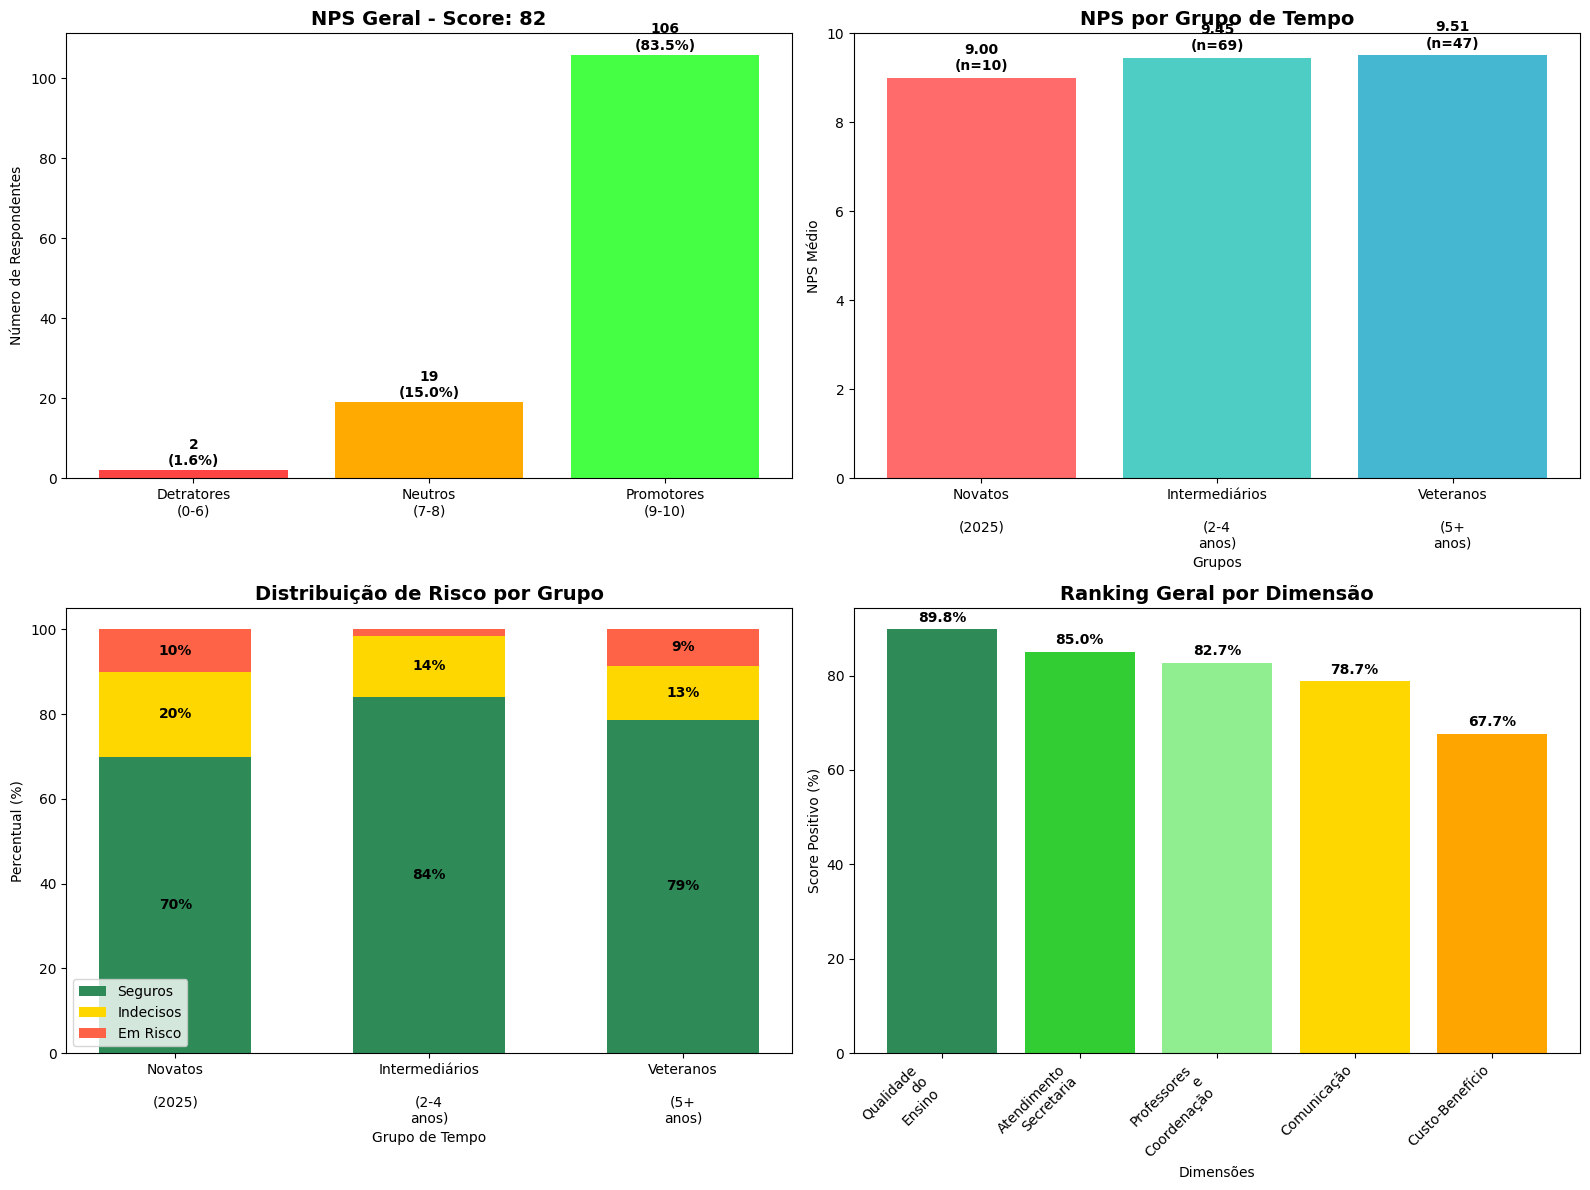

In [42]:
print("\n" + "="*50)
print("10. 📊 GERANDO VISUALIZAÇÕES")
print("="*50)

# Figura 1: Visão Geral
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: NPS Geral
nps_categories = ['Detratores\n(0-6)', 'Neutros\n(7-8)', 'Promotores\n(9-10)']
nps_values = [detratores, neutros, promotores]
colors_nps = ['#ff4444', '#ffaa00', '#44ff44']

bars1 = ax1.bar(nps_categories, nps_values, color=colors_nps)
ax1.set_title(f'NPS Geral - Score: {nps_final}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Respondentes')

for bar, value in zip(bars1, nps_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value}\n({value/len(nps_scores)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Gráfico 2: NPS por Grupo de Tempo
grupos_3_nps = {}
for grupo in grupos_principais:
    if grupo in nps_por_tempo.index:
        grupos_3_nps[grupo] = nps_por_tempo.loc[grupo, 'mean']

if grupos_3_nps:
    grupos_nomes = list(grupos_3_nps.keys())
    grupos_valores = list(grupos_3_nps.values())
    cores_3_grupos = [cores_grupos[grupo] for grupo in grupos_nomes]

    bars2 = ax2.bar(range(len(grupos_nomes)), grupos_valores, color=cores_3_grupos)
    ax2.set_title('NPS por Grupo de Tempo', fontsize=14, fontweight='bold')
    ax2.set_ylabel('NPS Médio')
    ax2.set_xlabel('Grupos')
    ax2.set_xticks(range(len(grupos_nomes)))
    ax2.set_xticklabels([grupo.replace(' ', '\n').replace('(', '\n(') for grupo in grupos_nomes])
    ax2.set_ylim(0, 10)

    for i, (bar, value) in enumerate(zip(bars2, grupos_valores)):
        height = bar.get_height()
        count_grupo = nps_por_tempo.loc[grupos_nomes[i], 'count']
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{value:.2f}\n(n={count_grupo})', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Distribuição de Risco por Grupo
grupos_risco_3 = []
seguros_3 = []
indecisos_pct_3 = []
risco_pct_3 = []

for grupo in grupos_principais:
    if grupo in dados_risco_tempo:
        grupos_risco_3.append(grupo.replace(' ', '\n').replace('(', '\n('))
        seguros_3.append(dados_risco_tempo[grupo]['Seguros'])
        indecisos_pct_3.append(dados_risco_tempo[grupo]['Indecisos'])
        risco_pct_3.append(dados_risco_tempo[grupo]['Em Risco'])

if grupos_risco_3:
    x = range(len(grupos_risco_3))
    width = 0.6

    bars_seg = ax3.bar(x, seguros_3, width, label='Seguros', color='#2E8B57')
    bars_ind = ax3.bar(x, indecisos_pct_3, width, bottom=seguros_3, label='Indecisos', color='#FFD700')
    bars_risk = ax3.bar(x, risco_pct_3, width,
                       bottom=[s+i for s,i in zip(seguros_3, indecisos_pct_3)],
                       label='Em Risco', color='#FF6347')

    ax3.set_title('Distribuição de Risco por Grupo', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Percentual (%)')
    ax3.set_xlabel('Grupo de Tempo')
    ax3.set_xticks(x)
    ax3.set_xticklabels(grupos_risco_3)
    ax3.legend()

    # Adicionar percentuais relevantes
    for i in range(len(grupos_risco_3)):
        if seguros_3[i] > 15:
            ax3.text(i, seguros_3[i]/2, f'{seguros_3[i]:.0f}%',
                    ha='center', va='center', fontweight='bold')
        if indecisos_pct_3[i] > 8:
            ax3.text(i, seguros_3[i] + indecisos_pct_3[i]/2, f'{indecisos_pct_3[i]:.0f}%',
                    ha='center', va='center', fontweight='bold')
        if risco_pct_3[i] > 5:
            ax3.text(i, seguros_3[i] + indecisos_pct_3[i] + risco_pct_3[i]/2, f'{risco_pct_3[i]:.0f}%',
                    ha='center', va='center', fontweight='bold')

# Gráfico 4: Ranking Geral das Dimensões
dimensao_nomes = [nome for nome, score in ranking]
dimensao_scores = [score for nome, score in ranking]

bars4 = ax4.bar(range(len(dimensao_nomes)), dimensao_scores,
                color=['#2E8B57', '#32CD32', '#90EE90', '#FFD700', '#FFA500'])
ax4.set_title('Ranking Geral por Dimensão', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score Positivo (%)')
ax4.set_xlabel('Dimensões')
ax4.set_xticks(range(len(dimensao_nomes)))
ax4.set_xticklabels([nome.replace(' ', '\n') for nome in dimensao_nomes], rotation=45, ha='right')

for bar, value in zip(bars4, dimensao_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

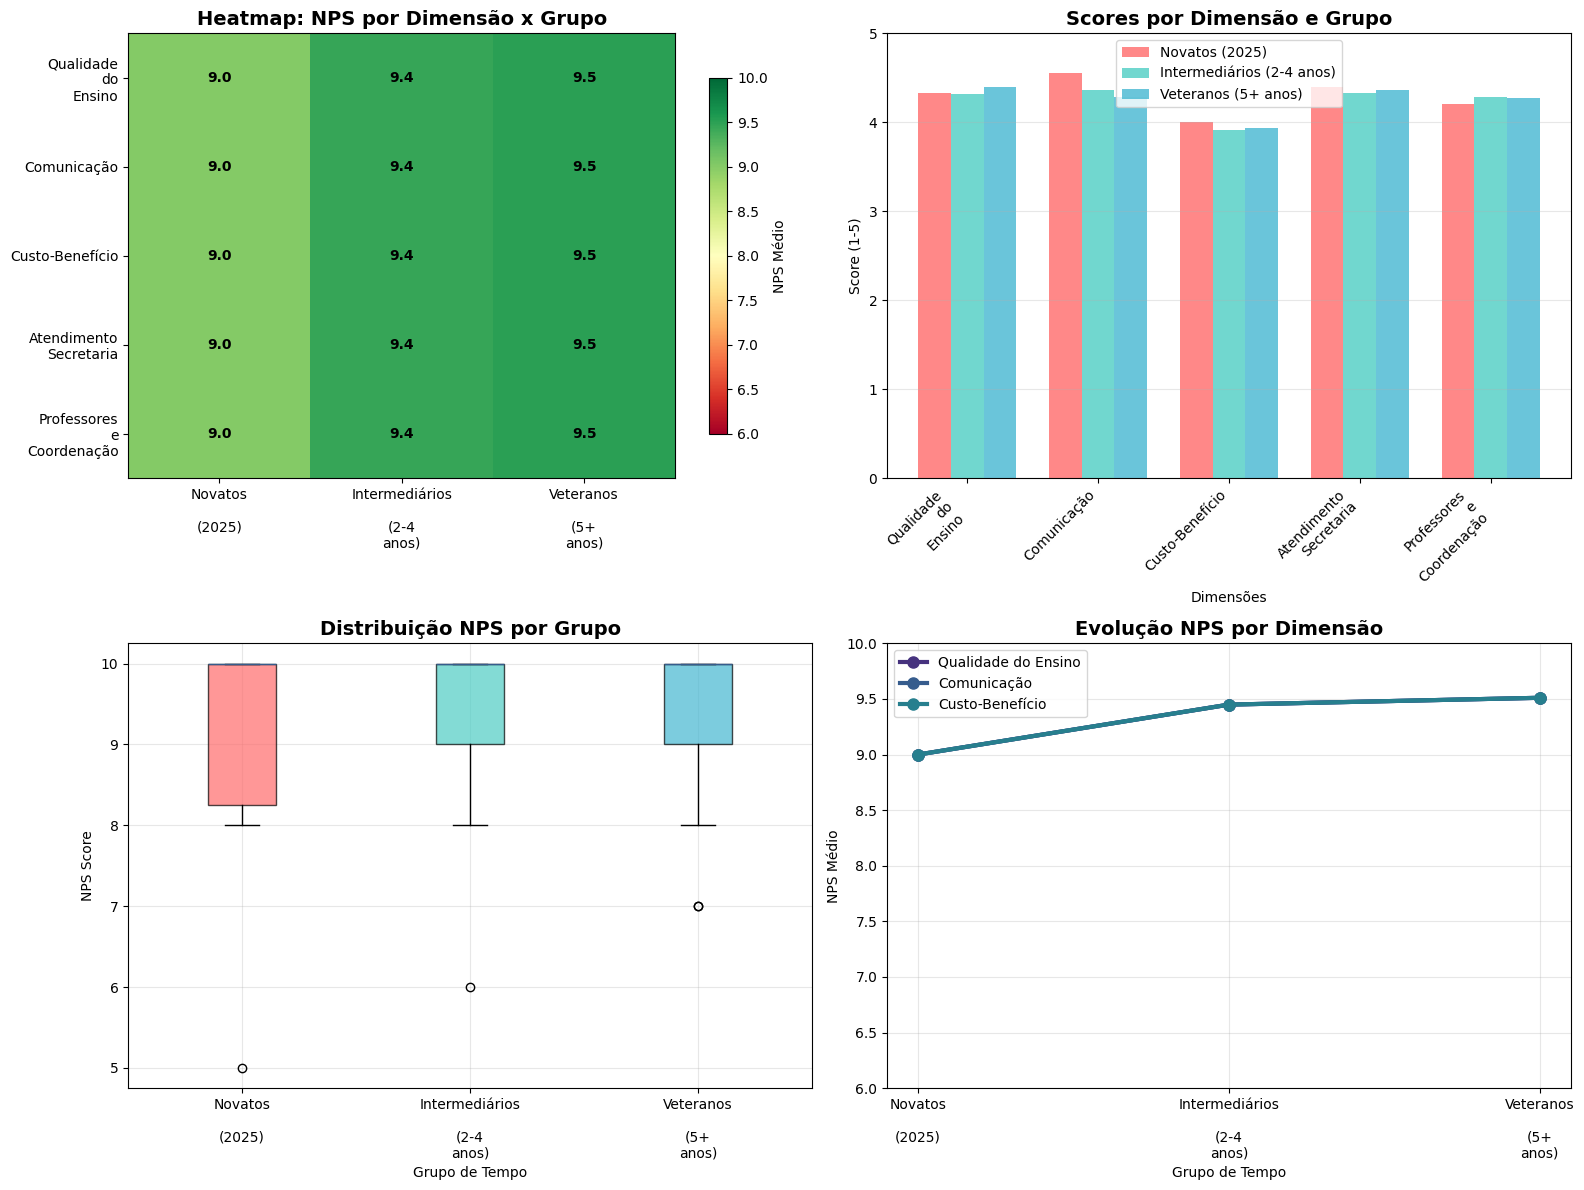

In [43]:
# Figura 2: Análises Avançadas por Grupo
fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 5: Heatmap NPS por Dimensão e Grupo
dimensoes_para_heatmap = list(dimensoes.values())
matriz_heatmap_3 = np.zeros((len(dimensoes_para_heatmap), len(grupos_principais)))
matriz_heatmap_3[:] = np.nan

for i, dimensao in enumerate(dimensoes_para_heatmap):
    for j, grupo in enumerate(grupos_principais):
        if dimensao in matriz_analise and grupo in matriz_analise[dimensao]:
            matriz_heatmap_3[i, j] = matriz_analise[dimensao][grupo]['nps_medio']

im = ax5.imshow(matriz_heatmap_3, cmap='RdYlGn', aspect='auto', vmin=6, vmax=10)
ax5.set_title('Heatmap: NPS por Dimensão x Grupo', fontsize=14, fontweight='bold')
ax5.set_xticks(range(len(grupos_principais)))
ax5.set_xticklabels([grupo.replace(' ', '\n').replace('(', '\n(') for grupo in grupos_principais])
ax5.set_yticks(range(len(dimensoes_para_heatmap)))
ax5.set_yticklabels([dim.replace(' ', '\n') for dim in dimensoes_para_heatmap])

# Adicionar valores no heatmap
for i in range(len(dimensoes_para_heatmap)):
    for j in range(len(grupos_principais)):
        if not np.isnan(matriz_heatmap_3[i, j]):
            ax5.text(j, i, f'{matriz_heatmap_3[i, j]:.1f}',
                    ha='center', va='center', fontweight='bold',
                    color='white' if matriz_heatmap_3[i, j] < 7.5 else 'black')

cbar = plt.colorbar(im, ax=ax5, shrink=0.8)
cbar.set_label('NPS Médio')

# Gráfico 6: Comparação de Scores por Dimensão
x = np.arange(len(dimensoes_para_heatmap))
width = 0.25

for i, grupo in enumerate(grupos_principais):
    scores_por_dimensao = []

    for dimensao in dimensoes_para_heatmap:
        if dimensao in matriz_analise and grupo in matriz_analise[dimensao]:
            score = matriz_analise[dimensao][grupo]['score_dimensao']
            scores_por_dimensao.append(score)
        else:
            scores_por_dimensao.append(0)

    ax6.bar(x + i*width, scores_por_dimensao, width,
            label=grupo, color=cores_grupos[grupo], alpha=0.8)

ax6.set_title('Scores por Dimensão e Grupo', fontsize=14, fontweight='bold')
ax6.set_ylabel('Score (1-5)')
ax6.set_xlabel('Dimensões')
ax6.set_xticks(x + width)
ax6.set_xticklabels([dim.replace(' ', '\n') for dim in dimensoes_para_heatmap], rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim(0, 5)

# Gráfico 7: Box Plot NPS por Grupo
dados_boxplot = []
labels_boxplot = []

for grupo in grupos_principais:
    if grupo in grupos_tempo.index:
        mask = df_analise['grupo_tempo'] == grupo
        nps_grupo = df_analise.loc[mask, nps_column].dropna()
        if len(nps_grupo) > 0:
            dados_boxplot.append(nps_grupo.values)
            labels_boxplot.append(grupo.replace(' ', '\n').replace('(', '\n('))

box_plot = ax7.boxplot(dados_boxplot, labels=labels_boxplot, patch_artist=True)

for i, patch in enumerate(box_plot['boxes']):
    if i < len(grupos_principais):
        patch.set_facecolor(cores_grupos[grupos_principais[i]])
        patch.set_alpha(0.7)

ax7.set_title('Distribuição NPS por Grupo', fontsize=14, fontweight='bold')
ax7.set_ylabel('NPS Score')
ax7.set_xlabel('Grupo de Tempo')
ax7.grid(True, alpha=0.3)

# Gráfico 8: Evolução NPS por Dimensão
for dimensao in ['Qualidade do Ensino', 'Comunicação', 'Custo-Benefício']:
    if dimensao in matriz_analise:
        nps_evolucao = []
        x_positions = []

        for i, grupo in enumerate(grupos_principais):
            if grupo in matriz_analise[dimensao]:
                nps_evolucao.append(matriz_analise[dimensao][grupo]['nps_medio'])
                x_positions.append(i)

        if len(nps_evolucao) >= 2:
            ax8.plot(x_positions, nps_evolucao, marker='o', linewidth=3,
                    markersize=8, label=dimensao)

ax8.set_title('Evolução NPS por Dimensão', fontsize=14, fontweight='bold')
ax8.set_xlabel('Grupo de Tempo')
ax8.set_ylabel('NPS Médio')
ax8.set_xticks(range(len(grupos_principais)))
ax8.set_xticklabels([g.replace(' ', '\n').replace('(', '\n(') for g in grupos_principais])
ax8.legend()
ax8.grid(True, alpha=0.3)
ax8.set_ylim(6, 10)

plt.tight_layout()
plt.show()

# ======================================
# 11. SÍNTESE EXECUTIVA E RECOMENDAÇÕES
# ======================================

In [44]:
print("\n" + "="*50)
print("11. 🎯 SÍNTESE EXECUTIVA E RECOMENDAÇÕES")
print("="*50)

print("\n🏆 PONTOS FORTES:")
print(f"• NPS Excelente: {nps_final} ({promotores} promotores)")
print(f"• Alta taxa de renovação provável: {renovacao_certa/total_intencoes*100:.1f}%")
melhor_dimensao = ranking[0]
print(f"• Dimensão líder: {melhor_dimensao[0]} ({melhor_dimensao[1]:.1f}%)")

print(f"\n⚠️ PONTOS DE ATENÇÃO:")
print(f"• {indecisos + em_risco} famílias em situação crítica ({(indecisos + em_risco)/total_intencoes*100:.1f}%)")
pior_dimensao = ranking[-1]
print(f"• Dimensão crítica: {pior_dimensao[0]} ({pior_dimensao[1]:.1f}%)")
print(f"• {categorias['Financeiro']} casos de risco financeiro")

print(f"\n🎯 ESTRATÉGIAS POR GRUPO:")

estrategias_especificas = {
    'Novatos (2025)': [
        "Welcome kit e integração intensiva",
        "Follow-up semanal nos primeiros 2 meses",
        "Canal direto para dúvidas",
        "Eventos de integração"
    ],
    'Intermediários (2-4 anos)': [
        "Relatórios de desenvolvimento do aluno",
        "Demonstração clara do ROI educacional",
        "Programas de desconto por fidelidade",
        "Comunicação sobre diferenciais únicos"
    ],
    'Veteranos (5+ anos)': [
        "Programa VIP com benefícios exclusivos",
        "Participação em decisões da escola",
        "Atendimento prioritário",
        "Reconhecimento da fidelidade"
    ]
}

for grupo, estrategias in estrategias_especificas.items():
    if grupo in dados_risco_tempo:
        risco_total = dados_risco_tempo[grupo]['Em Risco'] + dados_risco_tempo[grupo]['Indecisos']

        print(f"\n🎯 {grupo}:")
        print(f"   Risco: {risco_total:.1f}% | NPS: {nps_por_tempo.loc[grupo, 'mean']:.2f}")
        print(f"   Estratégias:")
        for estrategia in estrategias:
            print(f"   • {estrategia}")

print(f"\n📅 CRONOGRAMA DE AÇÃO:")
print(f"🚨 URGENTE (próximos 15 dias):")
print(f"   • Contato com {em_risco} famílias em risco de evasão")
print(f"   • Reunião com {indecisos} famílias indecisas")

print(f"\n⚡ RÁPIDO (próximos 30 dias):")
print(f"   • Implementar estratégias por grupo")
print(f"   • Programa de apoio financeiro")
print(f"   • Melhorias na dimensão mais crítica")

print(f"\n📊 MONITORAMENTO (próximos 60 dias):")
print(f"   • Pesquisa de follow-up")
print(f"   • Acompanhar impacto das ações")
print(f"   • Ajustar estratégias conforme resultados")


11. 🎯 SÍNTESE EXECUTIVA E RECOMENDAÇÕES

🏆 PONTOS FORTES:
• NPS Excelente: 82 (106 promotores)
• Alta taxa de renovação provável: 80.3%
• Dimensão líder: Qualidade do Ensino (89.8%)

⚠️ PONTOS DE ATENÇÃO:
• 25 famílias em situação crítica (19.7%)
• Dimensão crítica: Custo-Benefício (67.7%)
• 14 casos de risco financeiro

🎯 ESTRATÉGIAS POR GRUPO:

🎯 Novatos (2025):
   Risco: 30.0% | NPS: 9.00
   Estratégias:
   • Welcome kit e integração intensiva
   • Follow-up semanal nos primeiros 2 meses
   • Canal direto para dúvidas
   • Eventos de integração

🎯 Intermediários (2-4 anos):
   Risco: 15.9% | NPS: 9.45
   Estratégias:
   • Relatórios de desenvolvimento do aluno
   • Demonstração clara do ROI educacional
   • Programas de desconto por fidelidade
   • Comunicação sobre diferenciais únicos

🎯 Veteranos (5+ anos):
   Risco: 21.3% | NPS: 9.51
   Estratégias:
   • Programa VIP com benefícios exclusivos
   • Participação em decisões da escola
   • Atendimento prioritário
   • Reconheciment

# ======================================
# 12. SALVAR RELATÓRIOS
# ======================================

In [45]:
def salvar_relatorio_final():
    """Salva relatório executivo final"""
    with open('relatorio_cemel_3_grupos_final.txt', 'w', encoding='utf-8') as f:
        f.write("RELATÓRIO EXECUTIVO FINAL - CEMEL 2025\n")
        f.write("ANÁLISE POR 3 GRUPOS DE TEMPO\n")
        f.write("="*50 + "\n\n")

        f.write("RESUMO EXECUTIVO:\n")
        f.write(f"• NPS Geral: {nps_final} (Excelente)\n")
        f.write(f"• Taxa de renovação provável: {renovacao_certa/total_intencoes*100:.1f}%\n")
        f.write(f"• Famílias críticas: {indecisos + em_risco} ({(indecisos + em_risco)/total_intencoes*100:.1f}%)\n\n")

        f.write("PERFORMANCE POR GRUPO:\n\n")

        for grupo in grupos_principais:
            if grupo in dados_risco_tempo and grupo in nps_por_tempo.index:
                nps_grupo = nps_por_tempo.loc[grupo, 'mean']
                count_grupo = grupos_tempo[grupo]
                risco_total = dados_risco_tempo[grupo]['Em Risco'] + dados_risco_tempo[grupo]['Indecisos']

                f.write(f"{grupo}:\n")
                f.write(f"• Tamanho: {count_grupo} famílias ({count_grupo/len(df)*100:.1f}%)\n")
                f.write(f"• NPS: {nps_grupo:.2f}\n")
                f.write(f"• Risco total: {risco_total:.1f}%\n")

                if grupo in matriz_analise:
                    scores_grupo = {}
                    for dimensao, dados_grupos in matriz_analise.items():
                        if grupo in dados_grupos:
                            scores_grupo[dimensao] = dados_grupos[grupo]['score_dimensao']

                    if scores_grupo:
                        dim_critica = min(scores_grupo.items(), key=lambda x: x[1])
                        dim_forte = max(scores_grupo.items(), key=lambda x: x[1])
                        f.write(f"• Dimensão crítica: {dim_critica[0]} ({dim_critica[1]:.2f}/5.0)\n")
                        f.write(f"• Dimensão forte: {dim_forte[0]} ({dim_forte[1]:.2f}/5.0)\n")

                f.write(f"\n")

        f.write("AÇÕES PRIORITÁRIAS:\n")
        f.write("1. Intervenção imediata com famílias em risco\n")
        f.write("2. Estratégias específicas por grupo de tempo\n")
        f.write("3. Programa de apoio financeiro\n")
        f.write("4. Melhorias em infraestrutura/tecnologia\n")
        f.write("5. Sistema de monitoramento contínuo\n")

salvar_relatorio_final()

print("\n" + "="*60)
print("🎉 ANÁLISE COMPLETA - RELATÓRIO SALVO")
print("="*60)
print("✅ Arquivo salvo: 'relatorio_cemel_3_grupos_final.txt'")
print("📊 Gráficos gerados: Visão geral + Análises por grupo")
print("🎯 Estratégias definidas para os 3 grupos de tempo")
print("📋 Pronto para implementação das ações!")


🎉 ANÁLISE COMPLETA - RELATÓRIO SALVO
✅ Arquivo salvo: 'relatorio_cemel_3_grupos_final.txt'
📊 Gráficos gerados: Visão geral + Análises por grupo
🎯 Estratégias definidas para os 3 grupos de tempo
📋 Pronto para implementação das ações!
